In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import math 
import cv2
import re
from tqdm import tqdm

sns.set_style('dark')

# Face Recognition

<div class='alert alert-info'>A <strong>facial recognition system</strong> is a technology capable of matching a human face from a digital image or a video frame against a database of faces. Such a system is typically employed to authenticate users through ID verification services, and works by pinpointing and measuring facial features from a given image.</div>

<img src='https://www.thalesgroup.com/sites/default/files/database/assets/images/2020-07/gov-facial-recognition-in-action.jpg'>

In [3]:
data = pd.read_csv("/kaggle/input/celeba-face-recognition-triplets/CelebA FR Triplets/triplets.csv")
data = data.sample(frac=1).reset_index(drop=True)

In [4]:
data

anchor   id1         pos   id2         neg   id3
0      000588.jpg  3129  158861.jpg  3129  149801.jpg  6479
1      126003.jpg  7946  098971.jpg  7946  083834.jpg  1639
2      178724.jpg  1732  171814.jpg  1732  163958.jpg  2001
3      164524.jpg  2001  172426.jpg  2001  165484.jpg  1120
4      194687.jpg  6837  194416.jpg  6837  119790.jpg  2524
...           ...   ...         ...   ...         ...   ...
16327  197287.jpg  7883  202355.jpg  7883  186399.jpg  9053
16328  019131.jpg  3052  098400.jpg  3052  146148.jpg  6834
16329  139628.jpg  9996  126643.jpg  9996  059183.jpg  1944
16330  193578.jpg  5332  197551.jpg  5332  041770.jpg  2116
16331  008640.jpg  1297  060704.jpg  1297  154983.jpg  6065

[16332 rows x 6 columns]

# Typical Tasks in Face Recognition
- Generally Speaking, a facial recognition system can be used to accomplish two kinds of tasks
    - **Face Verification:** One-to-one match that compares a query face image against a template face image whose identity is being claimed.
    - **Face Identification:** One-to-many matches that compare a query face image against all the template images in the database to determine the identity of the query face.
    
<img src='https://drek4537l1klr.cloudfront.net/elgendy/v-8/Figures/10_img_0003.png'>

In [5]:
base = '/kaggle/input/celeba-face-recognition-triplets/CelebA FR Triplets/images'

In [6]:
train = data.head(14332)
test = data.tail(2000)

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input, Layer, Lambda, BatchNormalization 
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3, MobileNetV2, EfficientNetB3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# One Shot Learning

- One-shot learning is a classification task where one, or a few, examples are used to classify many new examples in the future.
- This characterizes tasks seen in the field of face recognition, such as face identification and face verification, where people must be classified correctly with different facial expressions, lighting conditions, accessories, and hairstyles given one or a few template photos.
- Modern face recognition systems approach the problem of one-shot learning via face recognition by learning a rich low-dimensional feature representation, called a face embedding, that can be calculated for faces easily and compared for verification and identification tasks.
- For our Face Recognition task we are going to produce vector embeddings of size **128** (FaceNet)

<div class='alert alert-info'><strong>FaceNet</strong> which is a one shot learning model training for face recognition takes a person's face and compresses it into a vector of 128 numbers. Ideally, embeddings of similar faces are also similar.</div>

<img src='https://www.researchgate.net/publication/345971024/figure/fig4/AS:958699908636682@1605583278305/Demonstration-of-One-Shot-Learning-technique.ppm'>

In [8]:
embeddings = tf.keras.models.load_model("/kaggle/input/facenet/keras-facenet/model/facenet_keras.h5")
embeddings.load_weights('/kaggle/input/facenet/keras-facenet/weights/facenet_keras_weights.h5')

In [9]:
embeddings.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

# Siamese Network for Face Recognition
- A Siamese neural network is an artificial neural network that uses the same weights while working in tandem on two different input vectors to compute comparable output vectors.
- Siamese Networks can be applied to different use cases, like detecting duplicates, finding anomalies, and face recognition.
- There are different ways to train a siamese network, but we will go with the triplet loss function
- **Triplet loss** is a loss function for machine learning algorithms where a reference input (called anchor) is compared to a matching input (called positive) and a non-matching input (called negative).

<img src='https://omoindrot.github.io/assets/triplet_loss/triplet_loss.png'>

In [13]:
img_size = 160

for layer in embeddings.layers: 
    if layer.name == 'Block8_3_ScaleSum':
        break
    layer.trainable = False
    
image_input1 = Input(shape=(img_size,img_size,3),name='Image1')
image_input2 = Input(shape=(img_size,img_size,3),name='Image2')
image_input3 = Input(shape=(img_size,img_size,3),name='Image3')

anchor = embeddings(image_input1)
positive = embeddings(image_input2)
negative = embeddings(image_input3)

siamese_network = Model(inputs=[image_input1,image_input2,image_input3], outputs=[anchor,positive,negative])
siamese_network.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image1 (InputLayer)             [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Image2 (InputLayer)             [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Image3 (InputLayer)             [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
inception_resnet_v1 (Functional (None, 128)          22808144    Image1[0][0]                     
                                                                 Image2[0][0]                 

# Triplet Generation
- We generate triplets to train our model 
1. **Anchor:** An input image
2. **Positive:** Same image as the identity in the input image
3. **Negative:** Different image than the identity in the input image

<img src='https://qdrant.tech/articles_data/triplet-loss/loss_objective.png'>

In [14]:
batch_size = 32
datagen = ImageDataGenerator(rescale=1/255.)

In [15]:
class TripleGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, gen1, gen2, gen3):
        
        self.gen1 = gen1
        self.gen2 = gen2
        self.gen3 = gen3

    def __len__(self):
        
        return len(self.gen1)

    def __getitem__(self, i):
        
        x1 = self.gen1[i]
        x2 = self.gen2[i]
        x3 = self.gen3[i]
        
        return [x1,x2,x3]

In [16]:
directory = '/kaggle/input/celeba-face-recognition-triplets/CelebA FR Triplets/images'

def create_generator(folder,dataset,column):
    generator = datagen.flow_from_dataframe(dataframe=dataset,
                                            directory=folder,
                                            x_col=column,
                                            target_size=(img_size, img_size),
                                            batch_size=batch_size,
                                            class_mode=None,
                                            shuffle=False)
    return generator

train_generator1 = create_generator(directory,train,'anchor')
train_generator2 = create_generator(directory,train,'pos')
train_generator3 = create_generator(directory,train,'neg')

test_generator1 = create_generator(directory,test,'anchor')
test_generator2 = create_generator(directory,test,'pos')
test_generator3 = create_generator(directory,test,'neg')

train_generator = TripleGenerator(train_generator1,train_generator2,train_generator3)
test_generator = TripleGenerator(test_generator1,test_generator2,test_generator3)

Found 14332 validated image filenames.
Found 14332 validated image filenames.
Found 14332 validated image filenames.
Found 2000 validated image filenames.
Found 2000 validated image filenames.
Found 2000 validated image filenames.


In [17]:
samples = train_generator[0]

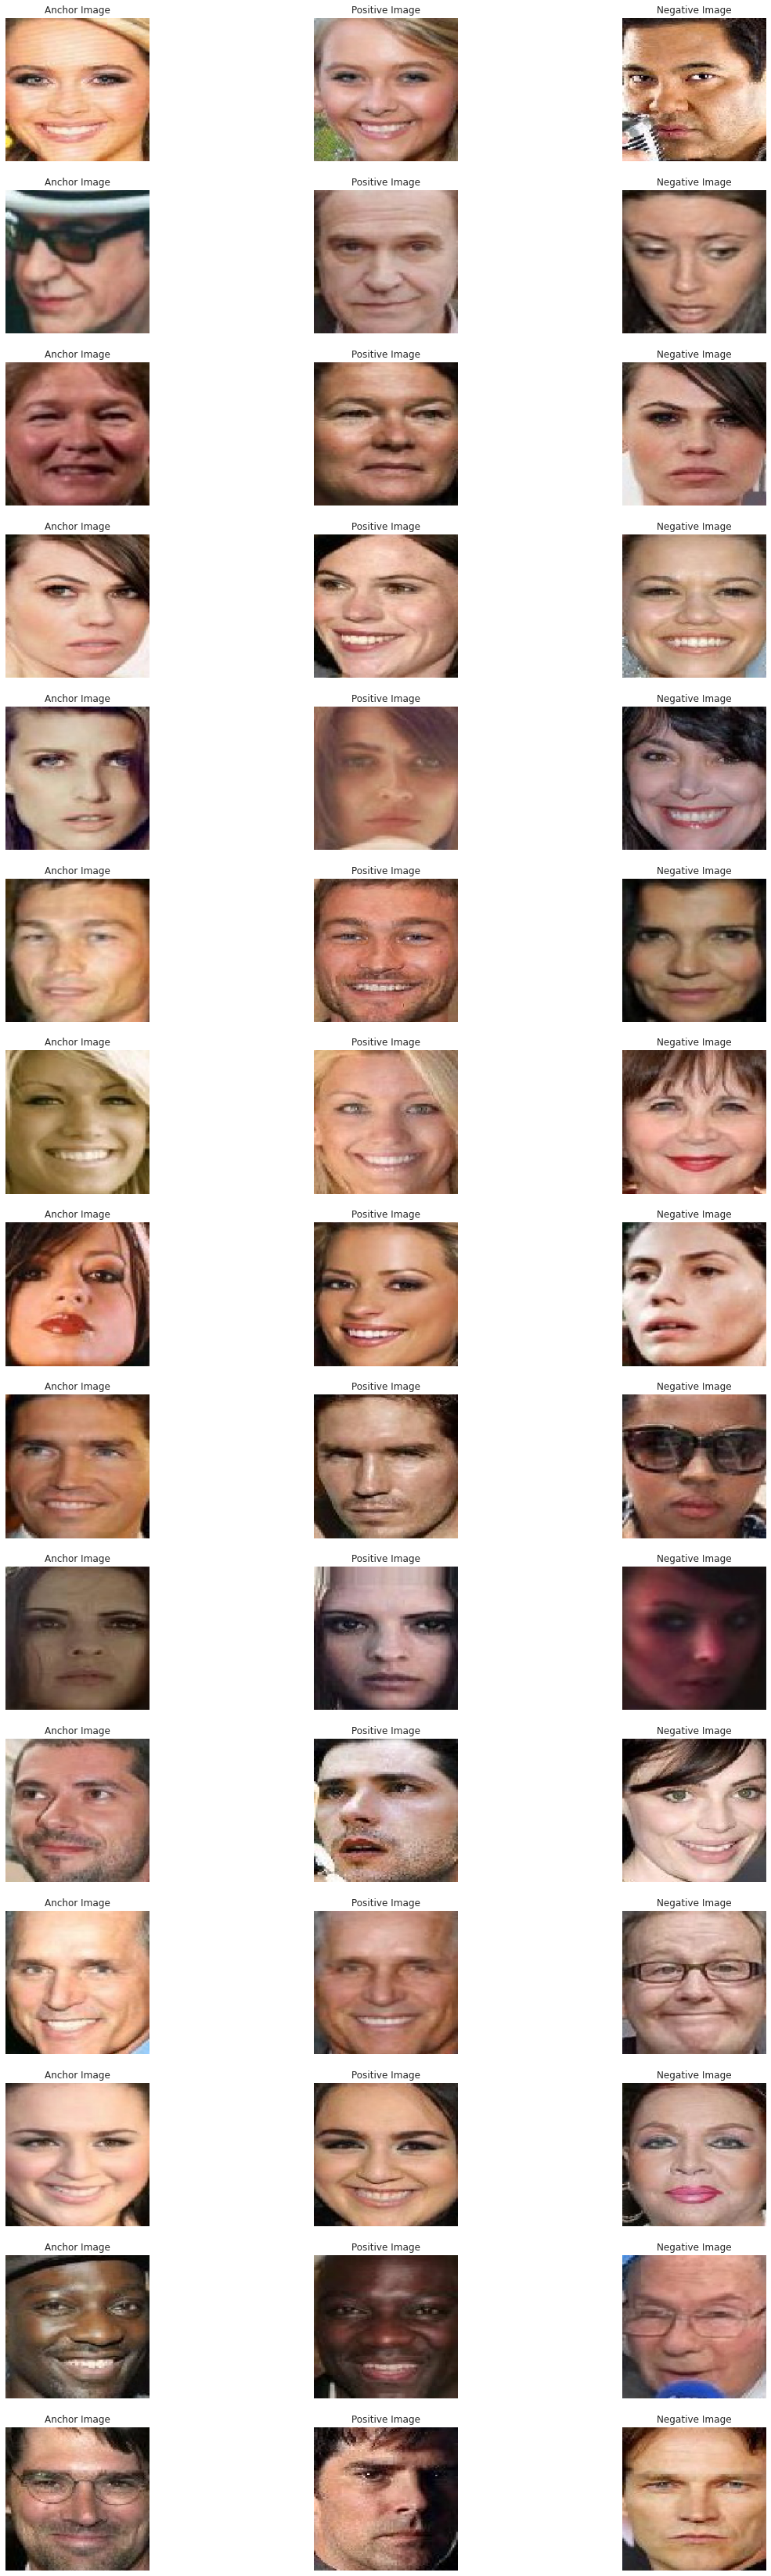

In [18]:
f, axarr = plt.subplots(15,3,figsize=(20, 60))

for i in range(0,15):

    axarr[i,0].imshow(samples[0][i])
    axarr[i,0].title.set_text('Anchor Image')
    axarr[i,0].axis('off')
    axarr[i,1].imshow(samples[1][i])
    axarr[i,1].title.set_text('Positive Image')
    axarr[i,1].axis('off')
    axarr[i,2].imshow(samples[2][i])
    axarr[i,2].title.set_text('Negative Image')
    axarr[i,2].axis('off')

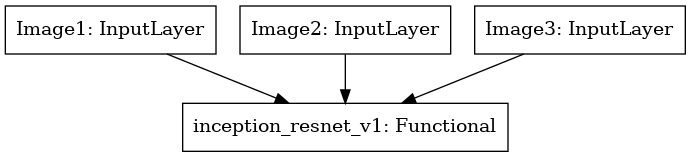

In [19]:
tf.keras.utils.plot_model(
    siamese_network,
    to_file='model.png')

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [21]:
model_path = "model.h5"
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1,
                             save_weights_only=True)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.3, 
                                            min_lr=0.00000001)

# Custom Model: Model Subclassing
- Since we are going to use custom inputs/outputs and a custom loss, it is a good idea to use model subclassing to define the custom features of our model
- **Loss Function:** Triplet Loss

<img src='https://blog.kakaocdn.net/dn/bh8XAu/btqw87frvWo/vcGVikKxlm1r0XTo3gKo80/img.png'>

In [22]:
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics

In [23]:
class SiameseModel(Model):
    
    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name='loss')
        
    def call(self, inputs):
        return self.siamese_network(inputs)
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
        gradients = tape.gradient(loss,self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(
                    zip(gradients,self.siamese_network.trainable_weights)
        )
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
    
    def test_step(self, data):
        loss = self._compute_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
    
    def _compute_loss(self, data):
        anchor, positive, negative = self.siamese_network(data)
        pos_dist = tf.reduce_sum(tf.square(anchor-positive), -1)
        neg_dist = tf.reduce_sum(tf.square(anchor-negative), -1)
        loss = pos_dist - neg_dist + self.margin
        loss = tf.maximum(loss, 0.0)
        return loss 
    
    @property
    def metrics(self):
        return [self.loss_tracker]

In [24]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001))

In [25]:
from sklearn.metrics.pairwise import euclidean_distances as L2

# Model Training

<div class='alert alert-warning'><strong>Note:</strong> Please note that this model is <strong>bound to overfit</strong> as we have very less number of triplets to train on (16000+). For tasks like Face Recognition it is a good idea to have large and diverse amount of triplet images. Since our objective is to only demonstrate the training of a siamese network for face recogniton we will finetune the model and use the best validation loss checkpointed model for inference (to avoid using the overfitted model)</div>

In [26]:
try:
    history = siamese_model.fit(train_generator, validation_data=test_generator,
                            epochs=50,callbacks=[checkpoint,earlystop,learning_rate_reduction]) 
except KeyboardInterrupt:
    print("\nTraining Stopped!")

Epoch 1/50
448/448 [==============================] - 241s 507ms/step - loss: 0.0780 - val_loss: 0.0342

Epoch 00001: val_loss improved from inf to 0.03421, saving model to model.h5
Epoch 2/50
448/448 [==============================] - 79s 175ms/step - loss: 0.0217 - val_loss: 0.0293

Epoch 00002: val_loss improved from 0.03421 to 0.02929, saving model to model.h5
Epoch 3/50
448/448 [==============================] - 78s 175ms/step - loss: 0.0110 - val_loss: 0.0380

Epoch 00003: val_loss did not improve from 0.02929
Epoch 4/50
448/448 [==============================] - 79s 176ms/step - loss: 0.0072 - val_loss: 0.0369

Epoch 00004: val_loss did not improve from 0.02929
Epoch 5/50
448/448 [==============================] - 80s 179ms/step - loss: 0.0051 - val_loss: 0.0335

Epoch 00005: val_loss did not improve from 0.02929
Epoch 6/50
448/448 [==============================] - 80s 177ms/step - loss: 0.0043 - val_loss: 0.0378

Epoch 00006: val_loss did not improve from 0.02929

Epoch 00006:

In [27]:
siamese_network.load_weights("model.h5")

In [28]:
y_pred = siamese_network.predict(test_generator)

In [29]:
from sklearn.metrics.pairwise import euclidean_distances as L2, cosine_similarity as cs

# Inference
- Lets calculate the L2 distance between all the anchor-positive and anchor-negative images
- We will then perform a statistical analysis to identify the ideal threshold to be used for the verification and identification tasks

In [30]:
test

anchor    id1         pos    id2         neg   id3
14332  002906.jpg    801  138966.jpg    801  110082.jpg  7993
14333  115015.jpg   7802  079996.jpg   7802  192024.jpg  9494
14334  117546.jpg   8393  054537.jpg   8393  149837.jpg  7056
14335  118516.jpg  10175  059929.jpg  10175  098802.jpg  5902
14336  046666.jpg     12  028858.jpg     12  023205.jpg  1705
...           ...    ...         ...    ...         ...   ...
16327  197287.jpg   7883  202355.jpg   7883  186399.jpg  9053
16328  019131.jpg   3052  098400.jpg   3052  146148.jpg  6834
16329  139628.jpg   9996  126643.jpg   9996  059183.jpg  1944
16330  193578.jpg   5332  197551.jpg   5332  041770.jpg  2116
16331  008640.jpg   1297  060704.jpg   1297  154983.jpg  6065

[2000 rows x 6 columns]

In [31]:
distances = []
for i in range(len(test)):
    pos = L2(y_pred[0][i,:].reshape(1,-1),y_pred[1][i,:].reshape(1,-1))[0][0]
    neg = L2(y_pred[0][i,:].reshape(1,-1),y_pred[2][i,:].reshape(1,-1))[0][0]
    distances.append([pos,neg])

In [32]:
test.loc[:,['pos_dist','neg_dist']] = distances

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [33]:
test

anchor    id1         pos    id2         neg   id3  pos_dist  \
14332  002906.jpg    801  138966.jpg    801  110082.jpg  7993  1.320903   
14333  115015.jpg   7802  079996.jpg   7802  192024.jpg  9494  1.551062   
14334  117546.jpg   8393  054537.jpg   8393  149837.jpg  7056  1.945457   
14335  118516.jpg  10175  059929.jpg  10175  098802.jpg  5902  1.401679   
14336  046666.jpg     12  028858.jpg     12  023205.jpg  1705  1.521561   
...           ...    ...         ...    ...         ...   ...       ...   
16327  197287.jpg   7883  202355.jpg   7883  186399.jpg  9053  1.118876   
16328  019131.jpg   3052  098400.jpg   3052  146148.jpg  6834  0.624825   
16329  139628.jpg   9996  126643.jpg   9996  059183.jpg  1944  1.441571   
16330  193578.jpg   5332  197551.jpg   5332  041770.jpg  2116  1.375918   
16331  008640.jpg   1297  060704.jpg   1297  154983.jpg  6065  1.286883   

       neg_dist  
14332  2.425373  
14333  2.678449  
14334  2.154317  
14335  2.636425  
14336  1.858897  
...         ...  
16327  2.572702  
16328  2.013503  
16329  2.033375  
16330  2.422032  
16331  2.668498  

[2000 rows x 8 columns]

## Descriptive Stats: Anchor-Postive Distance and Anchor-Negative Distance
- Lets analyze the IQR plots of distances

In [34]:
test.describe()

id1          id2           id3     pos_dist     neg_dist
count   2000.00000   2000.00000   2000.000000  2000.000000  2000.000000
mean    4920.01000   4920.01000   4918.136500     1.270407     2.150016
std     2966.72952   2966.72952   2871.892491     0.275359     0.341904
min        1.00000      1.00000     12.000000     0.000000     1.169356
25%     2279.50000   2279.50000   2395.500000     1.081736     1.898940
50%     4875.50000   4875.50000   4967.000000     1.246623     2.153434
75%     7441.00000   7441.00000   7355.000000     1.434498     2.396870
max    10176.00000  10176.00000  10176.000000     2.339513     3.093347

## Threshold Decision
- By looking at the descriptive stats and the IQR Box plots, trying out values between 1.5-2.0 for threshold will make sense

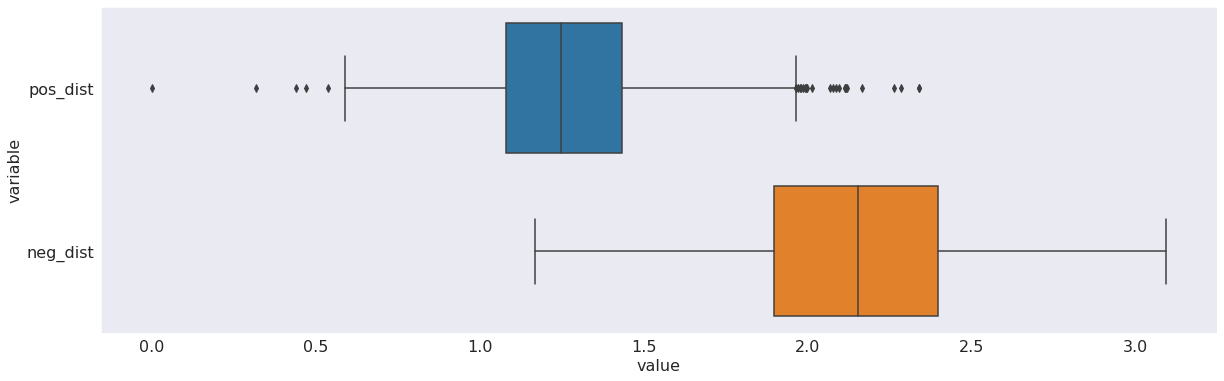

In [108]:
plt.figure(figsize=(20,6))
sns.boxplot(x="value", y="variable", data=pd.melt(test[['pos_dist','neg_dist']]))
plt.rc('font', size=20)
plt.show()

### Threshold of 1.65 gives correct decisions 83.55% of the time, so let's go with that. You can try out different values as well.

In [46]:
len(test[(test['pos_dist']<1.65) & (test['neg_dist']>1.65)])/len(test)

0.8355

# Extraction of Embeddings Model from Siamese Network
- Since we don't want to use the three input-three output siamese model every time we are required to create embeddings, we will extract the embeddings network from the model and use it to create embeddings for our future tasks

In [47]:
siamese_network.layers

In [48]:
face_embeddings = siamese_network.layers[-1]

In [49]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 47.9 MB/s eta 0:00:0000:01


# Inference Pipeline for Face Recognition Systems
- For detection of faces we will use MTCNN
- For the alignment, to maintain the simplicity of the scope of this kernel we will only use 2D alignment
- We will then use our model to extract the features

<img src='https://www.researchgate.net/publication/282863610/figure/fig1/AS:669508570214408@1536634690438/Processing-pipeline-of-face-recognition.jpg'>

In [50]:
from mtcnn import MTCNN

In [51]:
detector = MTCNN()

## Face Detection and Alignment
1. Detect the face using MTCNN
2. Use the eye landmarks to find the angle of rotation to align the face image
3. Detect the face in the rotated image
4. Use the detected face as ROI for our embeddings network

In [67]:
def euclidean(x1,y1,x2,y2):
    return ((x1-x2)**2 + (y1-y2)**2)**0.5

def align(x1,y1,x2,y2,img):
    x3,y3 = 0,0
    adj,hyp = 0,euclidean(x1,y1,x2,y2)
    angle = 0
    
    if y1 > y2:
        x3,y3 = x1,y2
        adj = euclidean(x3,y3,x2,y2)
        angle = -math.degrees(math.acos(adj/hyp))
    else:
        x3,y3 = x2,y1
        adj = euclidean(x3,y3,x1,y1)
        angle = math.degrees(math.acos(adj/hyp))
        
    M = cv2.getRotationMatrix2D((img.shape[1]//2,img.shape[0]//2), angle, 1)
    out = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    return out

def read_image(directory,image_path):
    img = load_img(os.path.join(directory,image_path))
    img = img_to_array(img)
    faces = detector.detect_faces(img)
    x1,y1 = faces[0]['keypoints']['left_eye']
    x2,y2 = faces[0]['keypoints']['right_eye']
    img = align(x1,y1,x2,y2,img)
    faces = detector.detect_faces(img)
    x,y,w,h = faces[0]['box']
    img = img[y:y+h,x:x+w,:]
    img /= 255.
    img = cv2.resize(img,(160,160))
    return img

In [68]:
directory = '/kaggle/input/ds-kimds'
img1 = read_image(directory,'isha1.jpeg')
img2 = read_image(directory,'isha5.jpeg')
img3 = read_image(directory,'ananya1.jpeg')

# Face Verification
- I have used the images of my undergrad students: Isha and Ananya (They look so alike ! Ikr ?)
- Lets calculate the L2 distance between their face embeddings

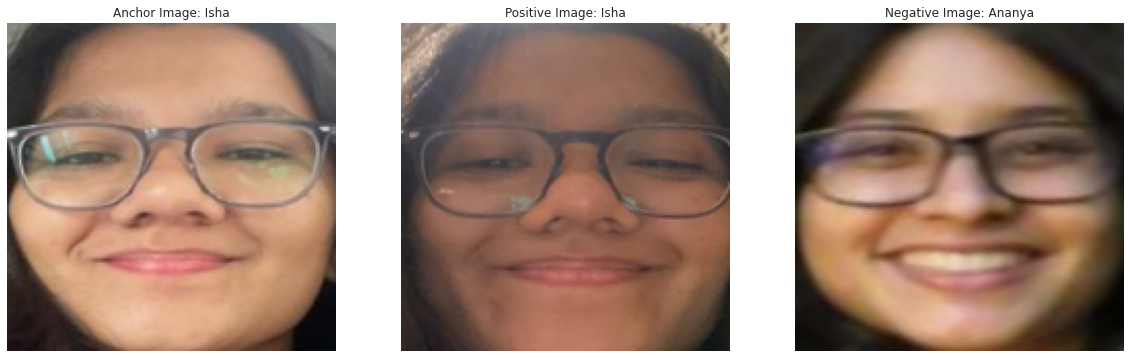

In [69]:
f, axarr = plt.subplots(1,3,figsize=(20, 8))
axarr[0].imshow(img1)
axarr[0].title.set_text('Anchor Image: Isha')
axarr[0].axis('off')
axarr[1].imshow(img2)
axarr[1].title.set_text('Positive Image: Isha')
axarr[1].axis('off')
axarr[2].imshow(img3)
axarr[2].title.set_text('Negative Image: Ananya')
axarr[2].axis('off')
plt.show()

In [70]:
emb1 = face_embeddings.predict(np.expand_dims(img1,axis=0))
emb2 = face_embeddings.predict(np.expand_dims(img2,axis=0))
emb3 = face_embeddings.predict(np.expand_dims(img3,axis=0))

## Distance Between Anchor & Postive
- The L2 distance is less than 1.65

In [71]:
L2(emb1,emb2)

array([[1.5848799]], dtype=float32)

## Distance Between Anchor & Negative
- The L2 distance is greater than 1.65

In [72]:
L2(emb1,emb3)

array([[1.8084141]], dtype=float32)

## Hence, we can say that Ananya cannot falsely claim to be Isha if she uses our Face Recognition System. 

# Face Identification: Photo Tagging
- Identifying the identity of a person by matching his/her face embeddings with the embeddings present in the database

In [73]:
database_images = os.listdir('/kaggle/input/celebs')

In [74]:
images = sorted(database_images)
db_images = images[:9]
query_images = images[9:]

In [81]:
db_names = map(lambda x: x.split('.')[0], db_images)
db_names = list(db_names)

In [76]:
detected_faces = []
directory = '/kaggle/input/celebs'
for image in db_images:
    img = read_image(directory,image)
    detected_faces.append(img)

detected_faces = np.array(detected_faces)
db_embeddings = face_embeddings.predict(detected_faces)

## Database Images

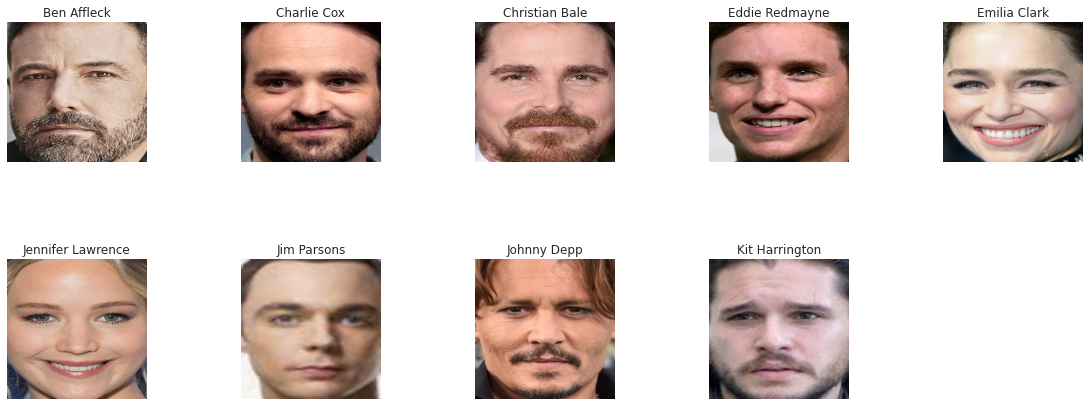

In [82]:
plt.figure(figsize = (20 , 20))
n = 0
for image,name in zip(detected_faces,db_names):
    n+=1
    plt.subplot(5 , 5, n)
    plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
    plt.imshow(image)
    plt.title(name)
    plt.axis("off")

In [78]:
db_embeddings.shape

(9, 128)

## Face Identification Query Function
1. Read an image
    - Detect face, perform alignment
2. Extract face embeddings
3. Calculate distance between embeddings present in the database and extracted input face embeddings
4. Find the index of the lowest distance, and check if distance is less than threshold
    - If yes then use the index to find the person from the database
    - Else the person in the input image is not present in the database
5. Use the OpenCV utilities to tag the person in the image

<div class='alert alert-info'><strong>Note:</strong> This is for tagging just one person in the image. So if more than one person is detected in the image, this function will tag the last detected person in the image. For tagging multiple people you can figure out how to write a loop to perform the same.</div>

In [105]:
def query_face(directory,filename,db_embeddings,db_names,thresh):
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 2
    color = (255, 255, 255)
    thickness = 4
    
    # 1
    query_img = read_image(directory,filename)
    query_img = np.expand_dims(query_img,axis=0)
    #2
    query_embedding = face_embeddings.predict(query_img)
    #3
    distances = L2(db_embeddings, query_embedding)
    
    #4
    index = np.argmin(distances,axis=0)
    q_index = index[0] if distances[index] < thresh else None
    label = 'Unknown'
    try:
        label = db_names[q_index]
    except TypeError:
        pass
    
    #5
    (width, height),b = cv2.getTextSize(label, font, fontScale, thickness)
    
    img = cv2.imread(os.path.join(directory,filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    faces = detector.detect_faces(img)
    x,y,w,h = faces[0]['box']

    img = cv2.rectangle(img, (x, y), (x+w, y+h), (51, 153, 255), 5)
    img = cv2.rectangle(img, (x, y-height), (x+width, y), (51, 153, 255), -1)
    img = cv2.putText(img, label, (x,y), font, 
                       fontScale, color, thickness, cv2.LINE_AA)
    
    return img

## Query Images

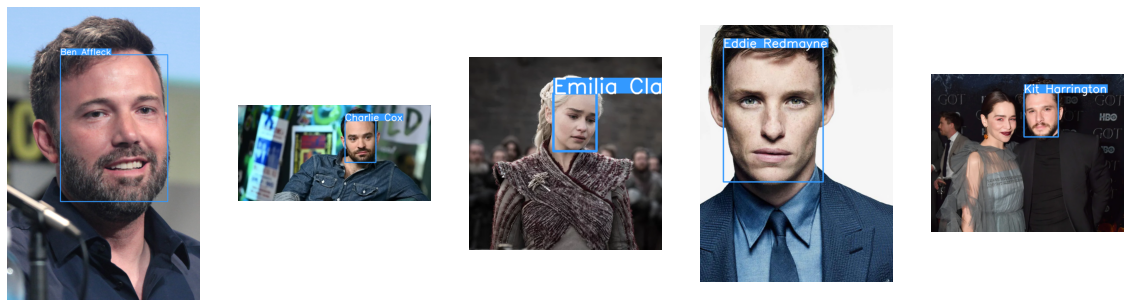

In [106]:
plt.figure(figsize = (20 , 20))
n = 0
for image in query_images:
    n+=1
    plt.subplot(2 , 5, n)
    img = query_face(directory,image,db_embeddings,db_names,1.65)
    plt.imshow(img)
    plt.axis("off")